In [345]:
# common imports
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import joblib, glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# display setup
pd.set_option("display.max_columns", None)  # the None parameter displays unlimited columns
plt.style.use('seaborn')  # for plots

# 1. Getting the Data

> Each participant has 3 csv files, one for each alignment state.

> Taking a look at a file should help gain insight to which DataFrame manipulations need to be implemented
> in the functions that will load the whole dataset.
>
> The 'HandRight' file contains right-hand movements which needs to be merged with the 'Alone' state files.
> Preparing it beforehand is more efficient since it will be used multiple times when loading the data.

In [139]:
# read right hand file
handright = pd.read_csv(r"extraFiles/HandRight.csv")

In [140]:
# display first 5 rows for a quick look
handright.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,0.270987,-0.017635,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,0.245085,-0.014770,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,0.230796,-0.008779,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,0.217681,-0.010759,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,0.220696,-0.017380,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [141]:
# DataFrame shape (rows, columns)
handright.shape

(4812, 22)

In [142]:
# description of data
handright.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [143]:
# show null values
handright.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

In [144]:
# should only contain 1 hand instances
handright[" # hands"].value_counts()

1    4732
2      80
Name:  # hands, dtype: int64

In [145]:
# should only contain right hand instances
handright[" Hand Type"].value_counts()

right    4738
left       74
Name:  Hand Type, dtype: int64

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: Frame number of detected movement
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The strength of a grab hand pose (values in range [0,1])
** Grab strength deprecated from version 2.0, use grab angle instead
13. Grab Angle: The angle between the fingers and the grab hand pose (0 to pi radians)
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: ID of the frame the hand belongs to
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The grab posture rating of the hand
13. Grab Angle: The average angle of the fingers to the hand
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

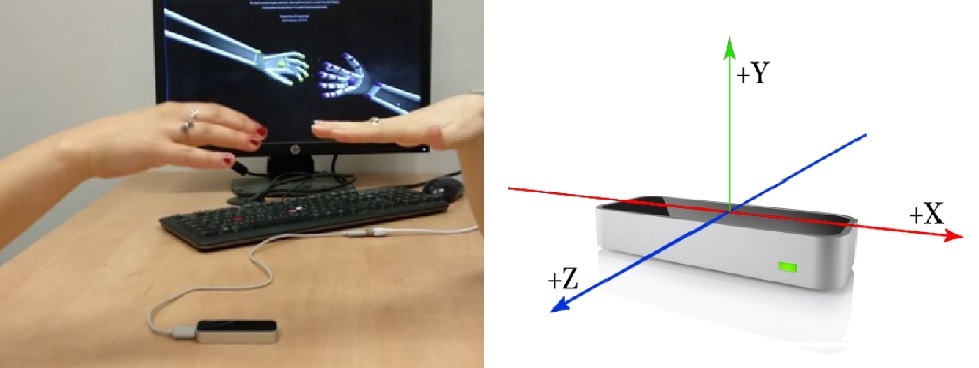

In [146]:
from IPython import display
display.Image("extraFiles/leap.jpg")

Clearly just by looking at a few files the data needs to be cleaned.

* Alone has instances with 2 hands and right hand in hand type that need to be removed. Likewise, spontaneous
and sync have instances with 1 hand and a mismatch between right and left hands.

In [147]:
def remove_first7(df):
    df.drop(df[df["Time"] < df["Time"].min() + 7].index, inplace=True)
    # drop is True to prevent from adding the old indices as a new column
    df.reset_index(drop=True, inplace=True)

In [148]:
print("Before:", handright.shape)
handright_prepared = handright.drop(handright[(handright[" Hand Type"] == "left") | (handright[" # hands"] == 2)].index)
handright_prepared.reset_index(drop=True, inplace=True)
remove_first7(handright_prepared)  # right hand file without first 7 seconds

Before: (4812, 22)


In [149]:
print("Null values:", handright_prepared.isna().sum().sum())
handright_prepared[handright_prepared.isna().any(axis=1)].head()

Null values: 2304


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
3893,201.8797,23959,right,1,-8.565041,140.3621,112.05200,32.42480,-145.06130,-160.3878,1.188079,-2.793904,-0.139680,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.0
3894,201.8968,23962,right,1,1.858126,112.7275,95.47443,497.33780,-642.50110,-686.8898,0.144945,0.010979,0.038722,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.418411,0.0
3895,201.9134,23963,right,1,2.825271,112.5456,91.11944,112.62890,-21.18921,-507.1606,0.143836,-0.002969,0.067269,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.379807,0.0
3896,201.9300,23965,right,1,3.694190,113.4331,82.37254,61.92186,95.66204,-499.7987,0.157899,-0.025162,0.093537,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.523864,0.0
3897,201.9464,23967,right,1,5.272612,115.7207,73.13319,107.58490,139.81950,-569.6603,0.149520,-0.008641,0.075155,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.715370,0.0


In [150]:
handright_prepared.dropna(inplace=True)
print("Null values:", handright_prepared.isna().sum().sum())
print("After:", handright_prepared.shape)
handright_prepared.head()

Null values: 0
After: (3893, 22)


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,0.108262,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,0.126925,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,0.127219,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,0.122782,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,0.127587,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


In [151]:
# split right hand file for training and testing
# train_size = round(len(handright_prepared) * 0.8)
# print(train_size)

# handright_prepared_train = handright_prepared.loc[:train_size].copy()
# handright_prepared_test = handright_prepared.loc[train_size:].copy()

# print("Right Hand Train\nShape:", handright_prepared_train.shape,
#      "\nNull Values:", handright_prepared_train.isna().sum().sum())
# print()
# print("Right Hand Test\nShape:", handright_prepared_test.shape,
#      "\nNull Values:", handright_prepared_test.isna().sum().sum())

> The following functions load the data into a DataFrame:

In [152]:
# function combines alone csv file with the right hand file

def combine_right(df_alone):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand prevents harming the DataFrame since it is used multiple times
    right = handright_prepared.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

In [323]:
# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    merged = left.merge(right, how="outer", on=["state", "time"])
    # adds a column with the second
    merged.insert(1, "round_time", merged.time.astype(int) - merged.time.min().astype(int))
    # return first 5 frames per second
    return merged.groupby("round_time").nth([0, 1, 2, 3, 4]).reset_index(drop=True) # round time is the index after groupby

> Rescaling the times in round time to start from zero rather than rounding the time values can create more diverse
> samples for each second. This is especially important for the 'alone' state, where the right hand is concatenated from
> the same file.

In [324]:
train_path = "extraFiles/Training/**/*.csv"
test_path = "extraFiles/Validation/**/*.csv"


def load_data(path, as_pandas):
    data = []
    # glob searches all directories and files
    for filename in glob.iglob(path, recursive=True):
        df = pd.read_csv(filename, index_col=None, header=0)
        remove_first7(df)  # removes first 7 seconds from file
        if "Alone" in filename:
            df = combine_right(df)
            df.insert(0, "state", 0)
        elif "Spontan" in filename:
            df.insert(0, "state", 1)
        elif "Sync" in filename:
            df.insert(0, "state", 2)
        df = transform_columns(df)
        data.append(df)
    if as_pandas:
        return pd.concat(data, axis=0, ignore_index=True)
    return data

In [325]:
# load the data
train_set = load_data(train_path, as_pandas=True)
test_set = load_data(test_path, as_pandas=True)

In [326]:
# display loaded data
train_set.head()

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
0,1,343.0061,-102.2870,198.3166,-2.122641,-174.57210,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.006620,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.000000,2.793122,0.329752
1,1,343.0227,-103.8721,201.4944,-2.063620,-178.50250,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.545550,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.000000,2.704073,0.293775
2,1,343.0392,-106.3691,207.4667,-2.337110,-126.78780,318.5284,-12.872290,1.441357,0.489946,1.496526,-168.4939,174.6985,-3.134404,-316.4541,-28.81729,-1.155143,0.0,1.865896,0.0,151.4056,203.4883,-38.14280,-14.11075,-56.448120,68.092860,0.637780,-0.134837,-0.554623,190.4547,169.7302,10.512530,324.1130,19.09524,161.3746,1.000000,2.422549,0.175940
3,1,343.0558,-107.9509,212.1324,-2.788956,-74.28078,244.4823,-30.771300,1.444497,0.483316,1.499930,-170.1878,179.6781,-4.185746,-315.3597,-25.78214,-9.287997,0.0,1.899355,0.0,151.6132,202.9217,-37.08601,21.48209,-21.234860,51.146260,0.608950,-0.142477,-0.548808,190.8024,170.2935,12.170700,323.0928,17.14600,161.7030,1.000000,2.101400,0.052777
4,1,343.0723,-109.5427,216.8003,-3.337280,-96.49666,269.5434,-37.723870,1.431969,0.488396,1.491886,-171.4205,183.7144,-4.797314,-311.4874,-25.01130,-16.183130,0.0,1.950082,0.0,152.4920,202.8671,-36.85715,57.06179,4.746809,17.712610,0.568949,-0.165198,-0.553877,192.5801,172.1215,12.837430,325.7650,19.51061,162.1241,0.849696,1.878483,0.000000


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [327]:
hands = train_set.copy()

In [328]:
hands.head(2)

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
0,1,343.0061,-102.2870,198.3166,-2.122641,-174.5721,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.0,2.793122,0.329752
1,1,343.0227,-103.8721,201.4944,-2.063620,-178.5025,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.54555,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.0,2.704073,0.293775


In [329]:
hands.shape

(9178, 38)

In [343]:
hands.sort_values("time").loc[400:450 , ["state", "time"]]

,state,time
400,2,446.0013
5414,1,446.0014
1300,1,446.0026
8068,0,446.0033
3763,1,446.0092
...,...,...
1348,1,455.0649
8117,0,455.0693
449,2,455.0796
1349,1,455.0818


In [340]:
hands.loc[1000:1050 , ["state", "time"]]

,state,time
1000,0,588.0019
1001,0,588.0178
1002,0,588.0347
1003,0,588.0510
1004,0,588.0684
1005,0,589.0117
1006,0,589.0283
1007,0,589.0449
1008,0,589.0615
1009,0,589.0786


In [310]:
hands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102167 entries, 0 to 102166
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   state                 102167 non-null  int64  
 1   time                  102167 non-null  float64
 2   position_x_left       102167 non-null  float64
 3   position_y_left       102167 non-null  float64
 4   position_z_left       102167 non-null  float64
 5   velocity_x_left       102167 non-null  float64
 6   velocity_y_left       102167 non-null  float64
 7   velocity_z_left       102167 non-null  float64
 8   pitch_left            102167 non-null  float64
 9   roll_left             102167 non-null  float64
 10  yaw_left              102167 non-null  float64
 11  wrist_pos_x_left      102167 non-null  float64
 12  wrist_pos_y_left      102167 non-null  float64
 13  wrist_pos_z_left      102167 non-null  float64
 14  elbow_pos_x_left      102167 non-null  float64
 15  

In [311]:
hands.isna().sum().sum()

0

In [161]:
hands.describe()

,state,time,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
count,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000,9178.000000
mean,1.000436,540.904154,-108.309485,204.987801,32.200270,-3.347259,0.496000,0.063305,0.991908,0.756315,1.084286,-149.844739,165.997731,40.945346,-313.832137,5.663559,75.810858,0.124499,0.835585,0.191928,92.724502,214.957965,39.525572,-3.337576,-3.837230,0.424354,0.805536,-0.622406,-0.688434,124.844715,176.550524,73.908597,267.600746,26.342787,187.013995,0.061602,0.498513,0.053815
std,0.815829,143.892276,52.200750,53.756587,55.012932,145.355979,214.508982,131.119334,0.939140,1.118846,0.879691,48.365396,49.367698,47.606455,61.100469,69.418601,64.597990,0.290326,0.925491,0.332978,65.769578,55.141745,55.002700,160.114646,262.775193,186.477881,0.607251,0.674553,0.627725,73.587454,50.828142,55.030820,97.752231,62.734502,102.121411,0.208683,0.660303,0.193522
min,0.000000,182.549200,-298.737100,66.096880,-157.595300,-1313.637000,-2354.559000,-1097.682000,-3.140563,-3.140818,-3.140881,-335.610400,3.553310,-117.151100,-512.740700,-188.209000,-102.684900,0.000000,0.000000,0.000000,-180.878400,59.404940,-152.757400,-1634.390000,-3180.031000,-2419.239000,-3.082958,-3.126932,-3.086131,-142.189800,23.062180,-133.482800,-28.691550,-193.459000,-57.144970,0.000000,0.000000,0.000000
25%,0.000000,435.034300,-136.126825,167.901125,0.972391,-68.835925,-96.721582,-55.137282,0.651558,0.254952,0.733505,-176.421325,133.378875,13.686630,-354.698200,-41.316207,27.009995,0.000000,0.000000,0.000000,32.079682,179.581975,0.308907,-57.906055,-117.162775,-74.545603,0.407460,-1.100950,-1.128745,52.417448,146.373475,33.202245,174.569000,-14.419038,104.417875,0.000000,0.035492,0.000000
50%,1.000000,541.045550,-103.085750,202.030050,31.225125,-4.523856,5.382333,2.242669,1.231009,0.913137,1.243266,-145.537000,160.962850,39.495970,-313.214100,-2.290812,75.672715,0.000000,0.528428,0.000000,112.165900,211.484100,37.349830,-0.980244,-3.107134,-4.152451,0.769004,-0.610584,-0.588357,151.727100,170.639050,74.627150,296.720750,19.519490,165.250350,0.000000,0.262596,0.000000
75%,2.000000,644.050175,-76.592148,235.285100,64.380782,59.442620,107.944650,58.657162,1.582799,1.380014,1.586228,-116.120175,189.952700,65.798150,-276.107425,39.647082,124.904625,0.000000,1.314505,0.278412,143.805725,246.725075,73.806015,57.780700,110.884275,67.929065,1.270733,-0.047043,-0.162170,184.129000,200.464650,114.283675,346.811375,62.865028,276.920900,0.000000,0.656001,0.000000
max,2.000000,856.163300,72.977780,478.120900,264.220200,1814.025000,1142.433000,1660.932000,3.138985,3.138921,3.139075,18.670390,438.209700,248.084500,-23.668370,377.966400,343.462200,1.000000,3.141593,1.000000,269.368900,434.498400,251.101300,1114.730000,1182.997000,1279.244000,3.136197,2.998879,0.931050,286.622200,419.043400,270.775600,503.926100,279.059500,518.593100,1.000000,3.141593,1.000000


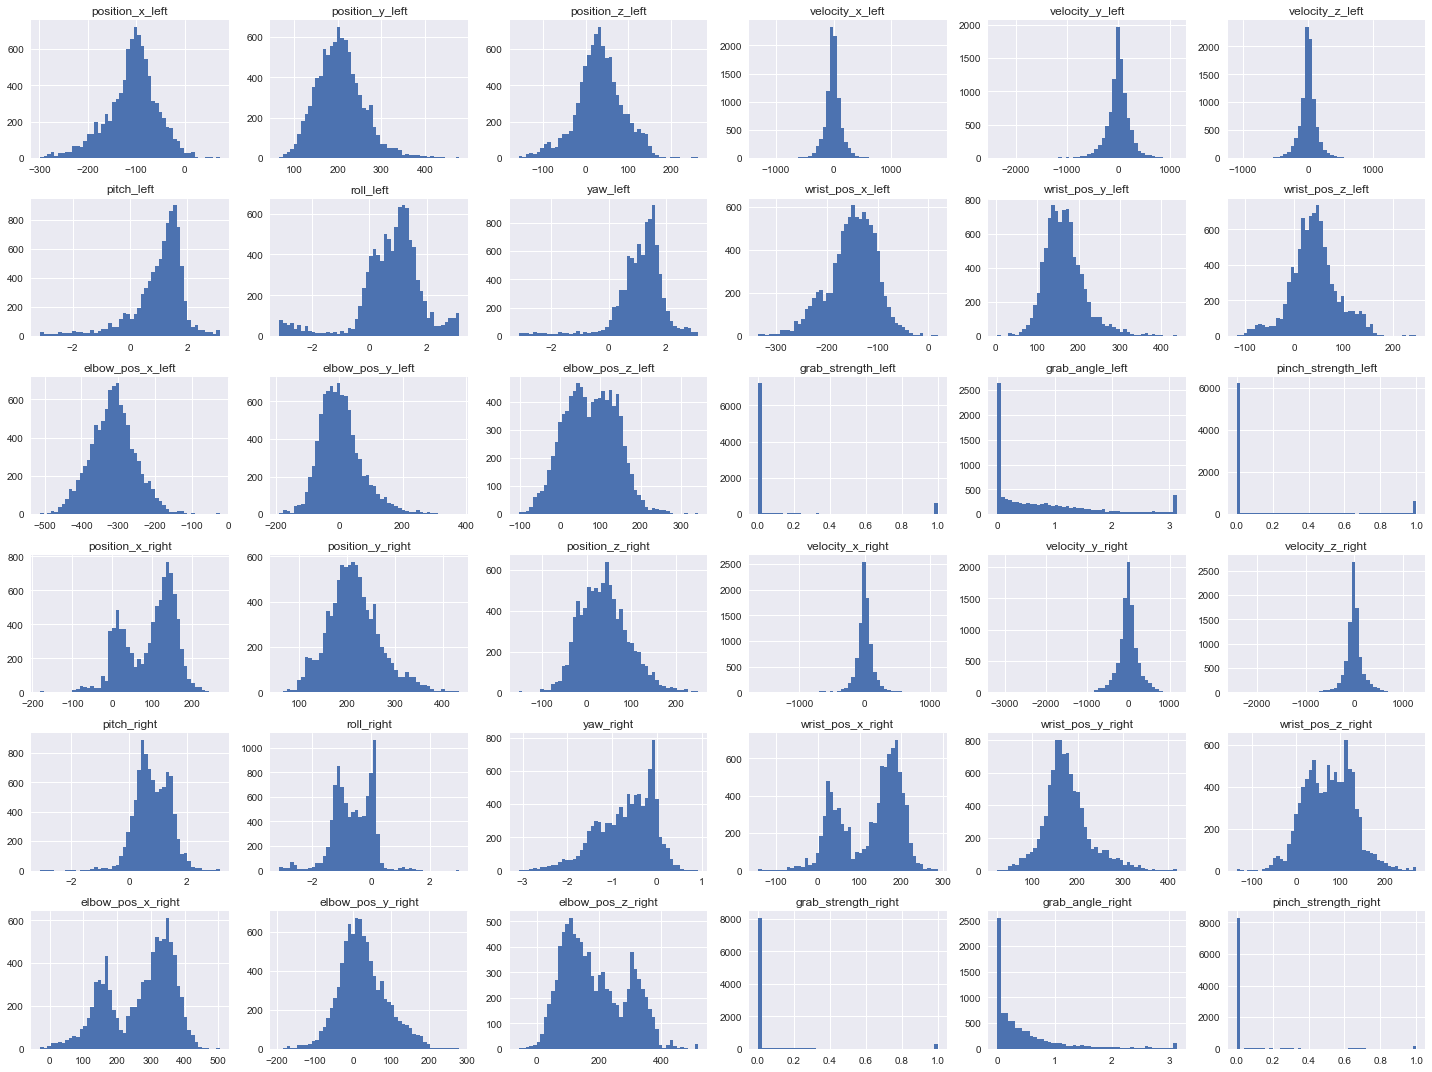

In [162]:
hands.drop(["state", "time"], axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

state_groups = hands.drop("time", axis=1, inplace=False).groupby("state")

state_groups.get_group(0).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color="red")
plt.suptitle("Alone", size=25)
plt.tight_layout()
plt.show()

state_groups.get_group(1).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color='orange')
plt.suptitle("Spontaneous", size=25)
plt.tight_layout()
plt.show()

state_groups.get_group(2).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color="green")
plt.suptitle("Sync", size=25)
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
1. The attributes have different scales. Some values are between 0-1, while others are in the range of hundreds or
even thousands and contain negative values.
2. Most of the attributes have a relatively normal distribution. Some are a bit tail-heavy (extend farther to the
left or right).

> ### Looking for Correlations:
> Correlations measure the linear relationships between the features.
> A strong positive correlation is close to 1 and a strong negative correlation is close to -1.
> Looking for correlations with the 'state' column can emphasize which features are most significant.

In [163]:
corr_matrix = hands.corr()

In [164]:
corr_matrix["state"].sort_values(ascending=False)

state                   1.000000
elbow_pos_x_right       0.697873
wrist_pos_x_right       0.638654
position_x_right        0.596378
pitch_right             0.443858
roll_left               0.220768
pitch_left              0.158856
time                    0.158131
position_z_left         0.135133
position_y_right        0.134826
wrist_pos_z_left        0.120733
position_y_left         0.051898
velocity_y_right        0.022784
grab_strength_right     0.022022
velocity_z_left         0.009091
velocity_x_right        0.006140
velocity_y_left         0.003244
velocity_x_left        -0.001158
velocity_z_right       -0.011938
wrist_pos_y_right      -0.016317
position_z_right       -0.031522
elbow_pos_z_left       -0.035144
yaw_left               -0.036122
pinch_strength_right   -0.064689
elbow_pos_x_left       -0.083043
wrist_pos_y_left       -0.099460
grab_strength_left     -0.108865
pinch_strength_left    -0.131348
grab_angle_right       -0.153511
wrist_pos_x_left       -0.210830
grab_angle

> Observations:
* From looking at the values, clearly the right hand has a greater influence than the left.
An assumption can be made that using the same right-hand data for all the 'alone' state files had an influence
on the right-hand correlations.
* Velocity has a low correlation for both hands and all three planes.
* Pinch and grab strength

> ### Evaluating Feature Combinations

> #### Combining position and wrist pos columns (by plane and hand type):

In [165]:
pos_cols = hands.filter(regex="wrist_pos|position").columns.tolist()
pos_cols

['position_x_left',
 'position_y_left',
 'position_z_left',
 'wrist_pos_x_left',
 'wrist_pos_y_left',
 'wrist_pos_z_left',
 'position_x_right',
 'position_y_right',
 'position_z_right',
 'wrist_pos_x_right',
 'wrist_pos_y_right',
 'wrist_pos_z_right']

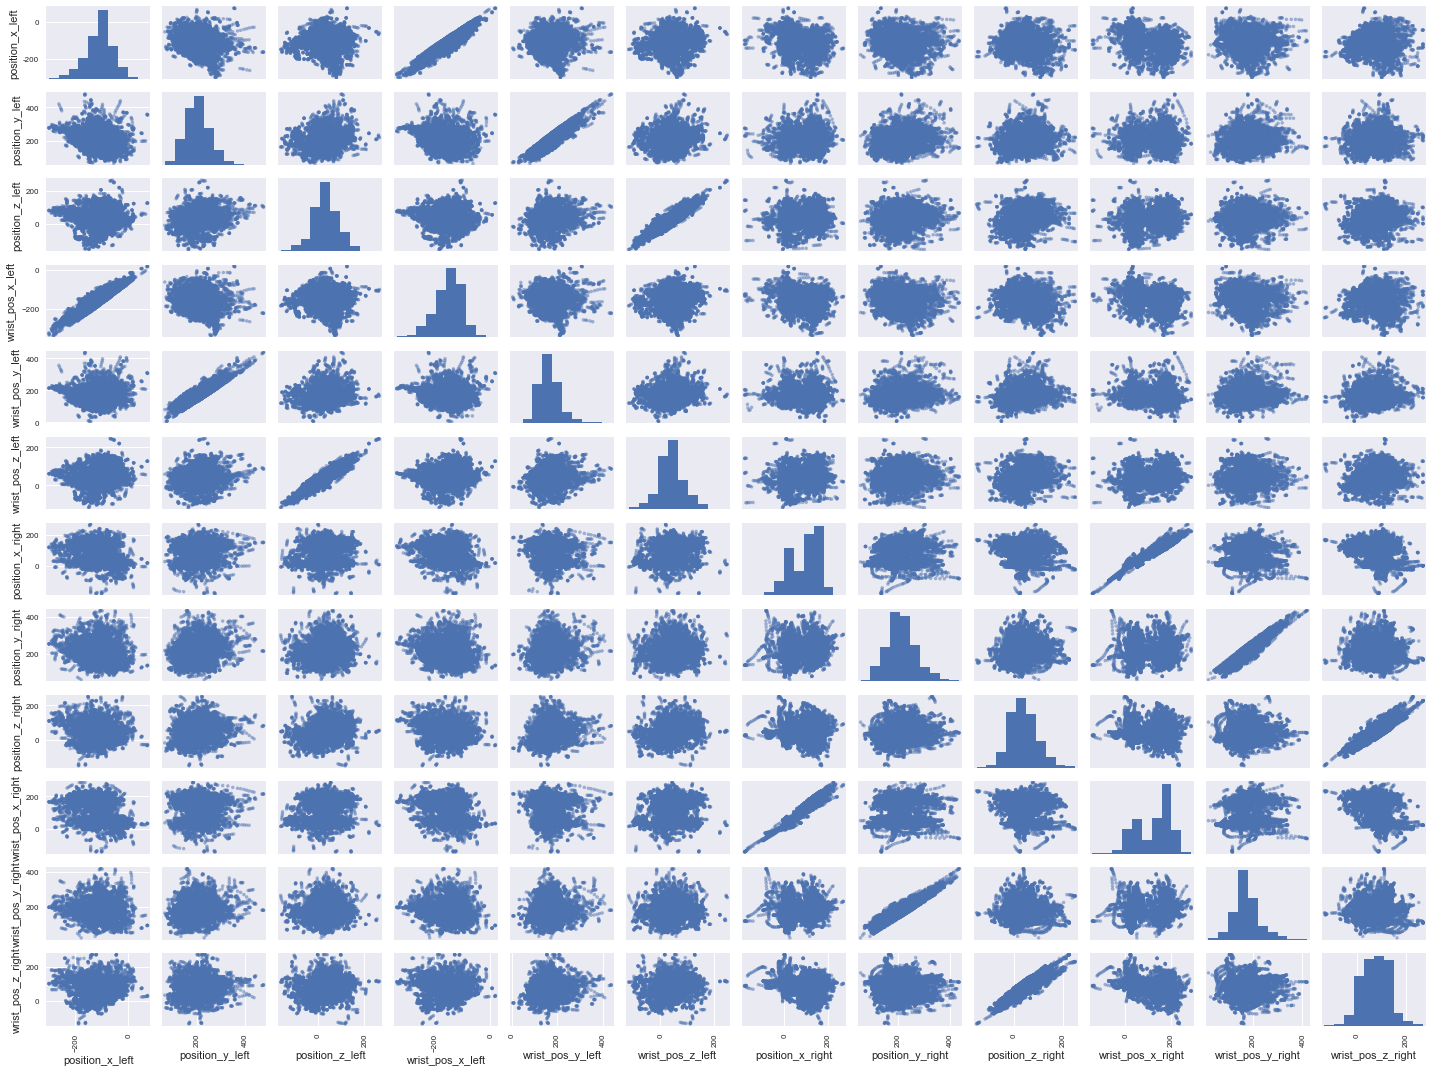

In [166]:
scatter_matrix(hands[pos_cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

In [167]:
hands.groupby("state")[pos_cols].agg(["mean", "min", "max"]).T

state                            0           1           2
position_x_left   mean  -83.494668 -118.637416 -122.716579
                  min  -275.933800 -262.097700 -298.737100
                  max    72.977780  -29.482990  -12.405510
position_y_left   mean  205.292998  197.577352  212.127402
                  min    66.096880   71.610270   70.183790
                  max   417.933700  478.120900  434.646200
position_z_left   mean   19.297784   39.724415   37.527254
                  min  -157.595300  -96.954800 -116.732700
                  max   264.220200  206.326900  174.879000
wrist_pos_x_left  mean -129.770178 -164.891104 -154.777729
                  min  -265.462000 -314.763100 -335.610400
                  max    18.670390  -64.192920  -44.363570
wrist_pos_y_left  mean  173.094212  163.862299  161.055752
                  min    74.058010    3.553310   28.865990
                  max   404.798100  438.209700  370.236900
wrist_pos_z_left  mean   29.166523   50.347954   43.263070
                  min  -117.151100  -82.313100  -77.628270
                  max   248.084500  185.919400  163.745800
position_x_right  mean   19.767813  142.127297  115.956583
                  min  -180.878400   58.242710  -79.975230
                  max   241.939500  234.778600  269.368900
position_y_right  mean  204.243329  218.130869  222.471139
                  min    59.404940   77.662180  101.343200
                  max   434.498400  424.584600  410.112900
position_z_right  mean   44.167357   34.524661   39.913682
                  min   -52.827330 -152.757400 -104.288100
                  max   251.101300  214.171600  203.427300
wrist_pos_x_right mean   36.869996  185.150377  152.122353
                  min  -142.189800  115.122100  -51.483030
                  max   202.718900  280.108700  286.622200
wrist_pos_y_right mean  174.810149  182.033489  172.780538
                  min    23.062180   31.697300   57.454870
                  max   419.043400  387.753300  354.340700
wrist_pos_z_right mean  106.094124   60.110667   55.626338
                  min    -4.467485 -133.482800  -73.748400
                  max   270.775600  249.799000  252.835900

> Looking at the values that match each position according to hand type and plane, it looks like the
> values are roughly in the same range. This means that the attribute combinations can be tested
> without normalizing beforehand.
>
> I will try combining the position features by plane and hand type into one by calculating the mean, a total of
> 6 new features.

In [168]:
# compute the mean into a new column

hands["mean_pos_x_left"] = (hands["wrist_pos_x_left"] + hands["position_x_left"]) / 2
hands["mean_pos_y_left"] = (hands["wrist_pos_y_left"] + hands["position_y_left"]) / 2
hands["mean_pos_z_left"] = (hands["wrist_pos_z_left"] + hands["position_z_left"]) / 2

hands["mean_pos_x_right"] = (hands["wrist_pos_x_right"] + hands["position_x_right"]) / 2
hands["mean_pos_y_right"] = (hands["wrist_pos_y_right"] + hands["position_y_right"]) / 2
hands["mean_pos_z_right"] = (hands["wrist_pos_z_right"] + hands["position_z_right"]) / 2

In [169]:
pos_cols = hands.filter(regex="wrist_pos|position|mean_pos").columns.tolist()
pos_cols

['position_x_left',
 'position_y_left',
 'position_z_left',
 'wrist_pos_x_left',
 'wrist_pos_y_left',
 'wrist_pos_z_left',
 'position_x_right',
 'position_y_right',
 'position_z_right',
 'wrist_pos_x_right',
 'wrist_pos_y_right',
 'wrist_pos_z_right',
 'mean_pos_x_left',
 'mean_pos_y_left',
 'mean_pos_z_left',
 'mean_pos_x_right',
 'mean_pos_y_right',
 'mean_pos_z_right']

In [170]:
corr_matrix = hands.corr()
corr_matrix["state"][pos_cols].sort_values(ascending=False)

wrist_pos_x_right    0.638654
mean_pos_x_right     0.623039
position_x_right     0.596378
position_z_left      0.135133
position_y_right     0.134826
mean_pos_z_left      0.131534
wrist_pos_z_left     0.120733
mean_pos_y_right     0.063620
position_y_left      0.051898
wrist_pos_y_right   -0.016317
mean_pos_y_left     -0.021189
position_z_right    -0.031522
wrist_pos_y_left    -0.099460
mean_pos_z_right    -0.209915
wrist_pos_x_left    -0.210830
mean_pos_x_left     -0.266161
position_x_left     -0.306440
wrist_pos_z_right   -0.374024
Name: state, dtype: float64

> Overall, it seems that the new columns represent the correlation well.
> It will be useful to implement a transformer for this to easily evaluate the results during model training.

> #### Combining grab strength and angle columns:

In [171]:
# get list of column names
grab_cols = hands.filter(regex="grab").columns.tolist()
grab_cols

['grab_strength_left',
 'grab_angle_left',
 'grab_strength_right',
 'grab_angle_right']

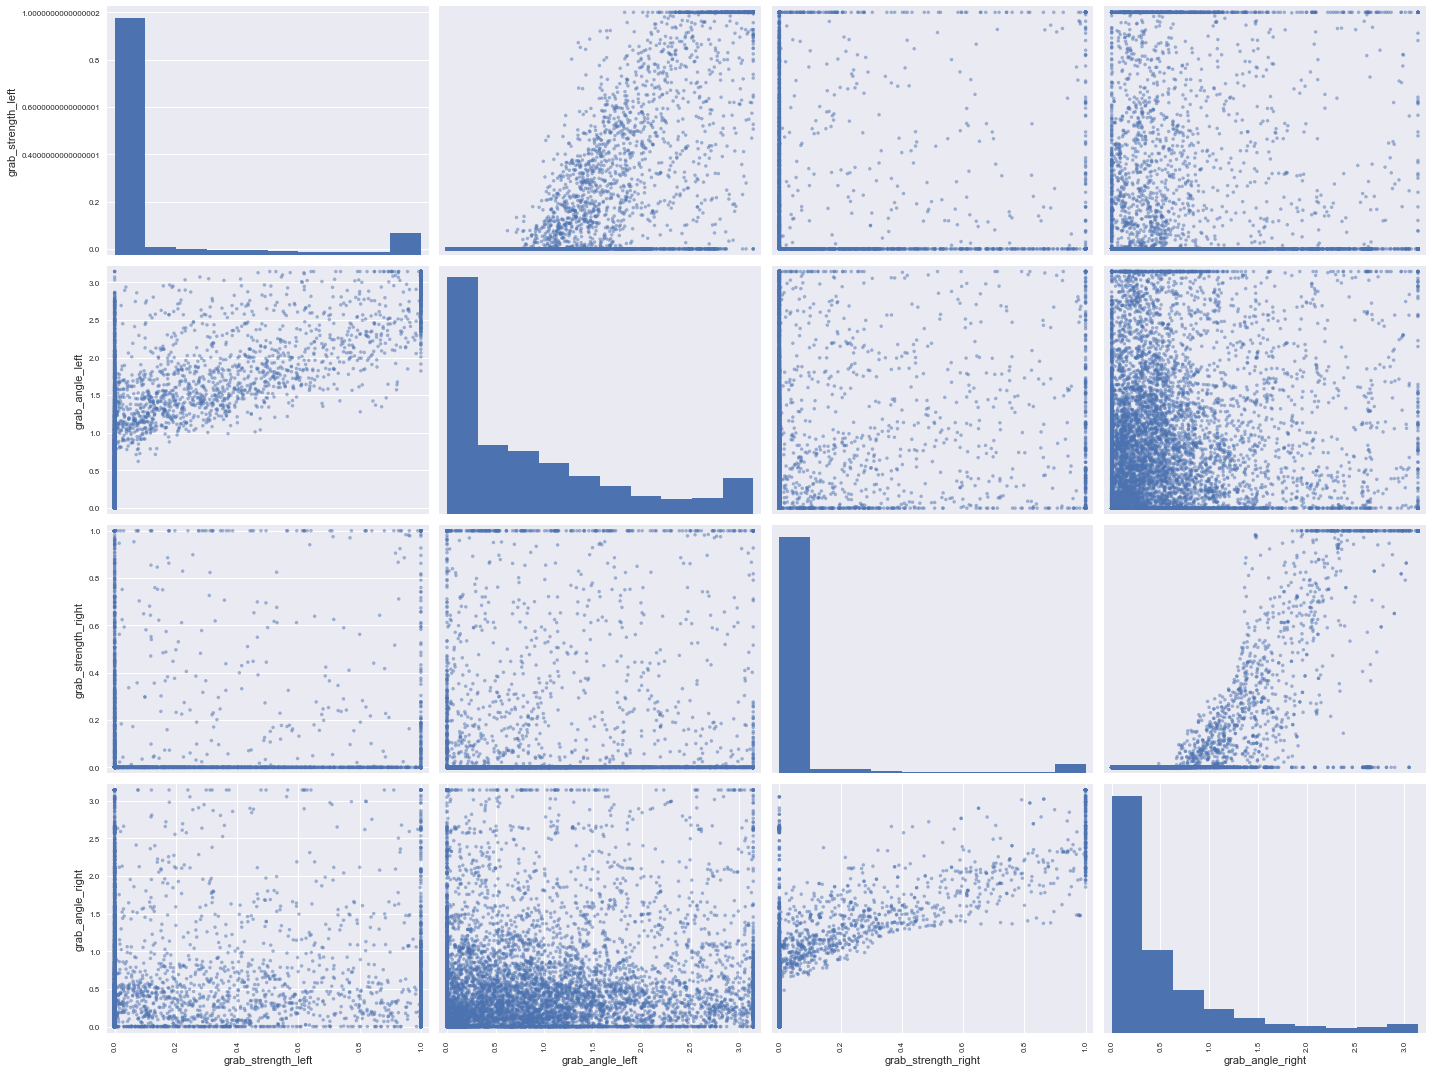

In [172]:
# plot correlation matrix
scatter_matrix(hands[grab_cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

> There is a pretty strong correlation between the grab angle and strength for each hand type.

In [173]:
# aggregate columns by alignment state
hands.groupby("state")[grab_cols].agg(["mean", "min", "max"]).T

state                            0         1         2
grab_strength_left  mean  0.158831  0.133315  0.081354
                    min   0.000000  0.000000  0.000000
                    max   1.000000  1.000000  1.000000
grab_angle_left     mean  1.012939  0.974416  0.518995
                    min   0.000000  0.000000  0.000000
                    max   3.141593  3.141593  3.141593
grab_strength_right mean  0.057707  0.058139  0.068971
                    min   0.000000  0.000000  0.000000
                    max   1.000000  1.000000  1.000000
grab_angle_right    mean  0.614013  0.516066  0.365531
                    min   0.000000  0.000000  0.000000
                    max   3.141593  3.141593  3.141593

> It is clear that strength is a value between 0 and 1 and the angle is between 0 and pi.
> In order to combine these features, I will first normalize the angle range to 0 and 1,
> then compute the mean, adding 2 new columns.

In [175]:
# normalize angle values to the same scale as grab strength
# angle = [0, pi], grab strength = [0, 1]
grab_angle_left_norm = hands["grab_angle_left"] / hands["grab_angle_left"].max()
grab_angle_right_norm = hands["grab_angle_right"] / hands["grab_angle_right"].max()

# compute the mean into a new column
hands["grab_left"] = (hands["grab_strength_left"] + grab_angle_left_norm) / 2
hands["grab_right"] = (hands["grab_strength_right"] + grab_angle_right_norm) / 2

In [176]:
# get list with added columns
grab_cols = hands.filter(regex="grab").columns.tolist()
grab_cols

['grab_strength_left',
 'grab_angle_left',
 'grab_strength_right',
 'grab_angle_right',
 'grab_left',
 'grab_right']

In [177]:
# show correlation with added columns
corr_matrix = hands.corr()
corr_matrix["state"][grab_cols].sort_values(ascending=False)

grab_strength_right    0.022022
grab_right            -0.069849
grab_strength_left    -0.108865
grab_angle_right      -0.153511
grab_left             -0.172937
grab_angle_left       -0.217748
Name: state, dtype: float64

> Observations:
* While grab left seems to provide a seemingly high correlation, grab right very little correlation
compared to grab angle right, which is a lot more correlated.
* Grab strength right has a positive correlation, unlike grab angle right and the newly combined feature, grab right.
* Overall, it seems that the new features mostly cause information loss and don't provide much more information
(especially the grab right feature, which is hardly correlated).
Therefore, I will not use it for further analysis.

In [180]:
# drop the combined feature columns
hands.drop(["grab_left", "grab_right"], axis=1, inplace=True)

# 3. Data Cleaning

In [228]:
# clean copy of the training set
df = train_set.copy()

In [372]:
# BaseEstimator for enabling hyperparameters
# TransformerMixin adds fit_transform method
class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, combine_position_wrist=False):
        self.combine_position_wrist = combine_position_wrist

    def fit(self, X, y=None):
        return self # no fitting needed

    def transform(self, X):
        mean_pos_x_left = (X["wrist_pos_x_left"] + X["position_x_left"]) / 2
        mean_pos_y_left = (X["wrist_pos_y_left"] + X["position_y_left"]) / 2
        mean_pos_z_left = (X["wrist_pos_z_left"] + X["position_z_left"]) / 2
        mean_pos_x_right = (X["wrist_pos_x_right"] + X["position_x_right"]) / 2
        mean_pos_y_right = (X["wrist_pos_y_right"] + X["position_y_right"]) / 2
        mean_pos_z_right = (X["wrist_pos_z_right"] + X["position_z_right"]) / 2
        if self.combine_position_wrist:
            # np.c_ concatenates slice objects along the second axis
            return np.c_[X, mean_pos_x_left, mean_pos_y_left, mean_pos_z_left,
                         mean_pos_x_right, mean_pos_y_right, mean_pos_z_right]
        return X.to_numpy() # return also in numpy format

hands = train_set.copy()
feat_adder = CombinedFeaturesAdder(combine_position_wrist=False)
feat_adder2 = CombinedFeaturesAdder(combine_position_wrist=True)
before = pd.DataFrame(feat_adder.transform(hands))
after = pd.DataFrame(feat_adder2.transform(hands))
after.drop([38, 39, 40, 41, 42, 43], axis=1, inplace=True)
(before != after).sum().sum()
#before

In [373]:
full_pipeline = Pipeline([
    ("feat_adder", CombinedFeaturesAdder(combine_position_wrist=True)),
    ("std_scl", StandardScaler())
])

### Notes:

01:37:00

- Organize the data in a pandas dataframe
- Goal: using the hand ... , detect if is alone, sync or spontaneous.
- "spontaneous synchronizing"
- interpersonal space
- training has 9 participants
- validation has different participants
- spontan and sync: if # hands is 1, remove data!
- time series
- every 2 lines is one feature (need to be combined) = 1 frame
- choose how many frames
- position y is similar
- 2 recordings, second is usually better
- can't split train and test as usual (correlation between each following movement). can't shuffle!
for instance, can take first 40 seconds for training and last 5 for testing.
- at least 2 seconds in between train and test
- model for 1 person, try model on second person. train the second person and test the third etc.
- 4 frames per second
-

> #### Resources:
1. Leap Motion Attributes <a href="https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html"
> title="leapmotion">link</a>

In [370]:
# function splits training data into a training set and validations set
# 2 second difference between train and validation

def split_train_val(data):
    train = []
    val = []
    for i in range(len(data)):
        df = data[i]
        train.append(df.drop(df[df["time"] > df["time"].max() - 7].index)) # drop last 7 seconds
        val.append(df.drop(df[df["time"] < df["time"].max() - 5].index)) # append last 5 seconds
    trainX = pd.concat(train, axis=0, ignore_index=True)
    valX = pd.concat(val, axis=0, ignore_index=True)
    return trainX, valX

In [371]:
trainX, valX = split_train_val(load_data(train_path, as_pandas=False))


training_data = []

# glob searches all directories and files
for filename in glob.iglob("extraFiles/Training/**/*.csv", recursive=True):
    df = pd.read_csv(filename, index_col=None, header=0)
    remove_first7(df) # removes first 7 seconds from file
    if "Alone" in filename:
        df = combine_right(df, False)
        df.insert(0, "state", 0)
    elif "Sync" in filename:
        df.insert(0, "state", 1)
    elif "Spontan" in filename:
        df.insert(0, "state", 2)
    df = transform_columns(df)
    training_data.append(df)

# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns2(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    return left.merge(right, how="outer", on=["state", "time"])

# function combines alone csv file with the right hand file

def combine_right2(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    if len(right) > len(df_alone):
        right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0
    else:
        df_alone = df_alone.loc[:len(right)-1]
    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

# function combines alone csv file with the right hand file

def combine_right(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

alone["Time"] = alone["Time"] - alone["Time"].min()

    # reset index (drop = False) adds round time as the left column in the DataFrame
    df = df.groupby("start_time").nth([0, 1, 2, 3]).reset_index() # first four instances per second

In [43]:
# adds a column with the second
new.insert(1, "round_time", new.time.astype(int) - new.time.min().astype(int))

NameError: name 'new' is not defined

In [ ]:
new

In [ ]:
# round time is the index after groupby
merged = new.groupby("round_time").nth([0, 1, 2, 3, 4]).reset_index(drop=True)

In [ ]:
merged.head(10)

In [ ]:
merged.isna().sum()

In [ ]:
merged

In [374]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X_train = trainX.drop("state", axis=1)
y_train = trainX.state.copy()
X_val = valX.drop("state", axis=1)
y_val = valX.state.copy()

In [375]:
X_train_prep = full_pipeline.fit_transform(X_train)

In [376]:
X_val_prep = full_pipeline.transform(X_val)

In [377]:
knn = KNeighborsClassifier()
knn.fit(X_train_prep, y_train)

KNeighborsClassifier()

In [378]:
pred = knn.predict(X_val_prep)

In [379]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       226
           1       0.91      0.81      0.86       230
           2       0.83      0.92      0.87       230

    accuracy                           0.91       686
   macro avg       0.91      0.91      0.91       686
weighted avg       0.91      0.91      0.91       686



In [360]:
print(metrics.classification_report(y_val, pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       226
           1       0.90      0.81      0.85       230
           2       0.83      0.91      0.87       230

    accuracy                           0.90       686
   macro avg       0.91      0.90      0.90       686
weighted avg       0.90      0.90      0.90       686



In [356]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       226
           1       0.89      0.82      0.85       230
           2       0.83      0.90      0.86       230

    accuracy                           0.90       686
   macro avg       0.90      0.90      0.90       686
weighted avg       0.90      0.90      0.90       686



In [380]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_prep, y_train)

RandomForestClassifier()

In [381]:
pred = rf_clf.predict(X_val_prep)

In [382]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       0.98      0.87      0.92       230
           2       0.89      0.98      0.93       230

    accuracy                           0.95       686
   macro avg       0.95      0.95      0.95       686
weighted avg       0.95      0.95      0.95       686



In [363]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       0.97      0.84      0.90       230
           2       0.86      0.97      0.91       230

    accuracy                           0.94       686
   macro avg       0.94      0.94      0.94       686
weighted avg       0.94      0.94      0.94       686



In [251]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       0.97      0.86      0.91       230
           2       0.87      0.97      0.92       230

    accuracy                           0.94       686
   macro avg       0.95      0.94      0.94       686
weighted avg       0.95      0.94      0.94       686

